In [2]:
# python v3.11.8
# import necessary packages

import os
import sys

import pandas as pd
import numpy as np

sys.path.append('functions')

from greatbrowser import great_analysis

from gene_analysis_functions import get_cistrome, get_pos, insig_nan
from pseudoinverse_functions import pinv_dropmin, quality_filter, trait_cluster, count_cumulative_probes

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
'''
Establich cwd, get relevant data, and perform basic formatting
'''

# set directory, import data, drop undefined
os.chdir('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\raw_data')
data = pd.read_excel('methylation_phenotype_encoded.xlsx', index_col=0) # mm39
data = data.dropna()

# referring to the point in the data where methylation and phenotype data diverge
sep=55

# seperate trait and methylation data
trait_data = data[:sep]
meth_data = data[sep:]

print(f'{trait_data.shape[0]} traits')

55 traits


In [4]:
# filter trait data to minimize colinearity
filter = 0.70
f_trait_data = quality_filter(trait_data, filter)

print(f'{f_trait_data.shape[0]} traits')

24 traits


                      627       629       630       633       636       637  \
ID                                                                            
cg06259996_TC21  0.146211  0.154260  0.121491  0.152565  0.144413  0.149819   
cg11548411_BC21  0.223298  0.186412  0.161515  0.184568  0.213074  0.200262   
cg28108944_BC11  0.532768  0.561110  0.550777  0.522043  0.512268  0.565786   
cg28108956_TC21  0.524625  0.527707  0.494442  0.482677  0.522701  0.532902   
cg28108957_BC21  0.549606  0.533730  0.499107  0.498348  0.492761  0.533865   
...                   ...       ...       ...       ...       ...       ...   
cg48343211_TC11  0.205879  0.435466  0.505348  0.515448  0.291100  0.446730   
cg48343225_BC11  0.095217  0.377419  0.254311  0.346717  0.297155  0.289252   
cg48343290_TC21  0.385949  0.208931  0.252605  0.289938  0.367722  0.236867   
cg48343860_TC21  0.384463  0.702253  0.652929  0.571051  0.407764  0.431368   
cg48344016_TC11  0.812896  0.801188  0.798169  0.819

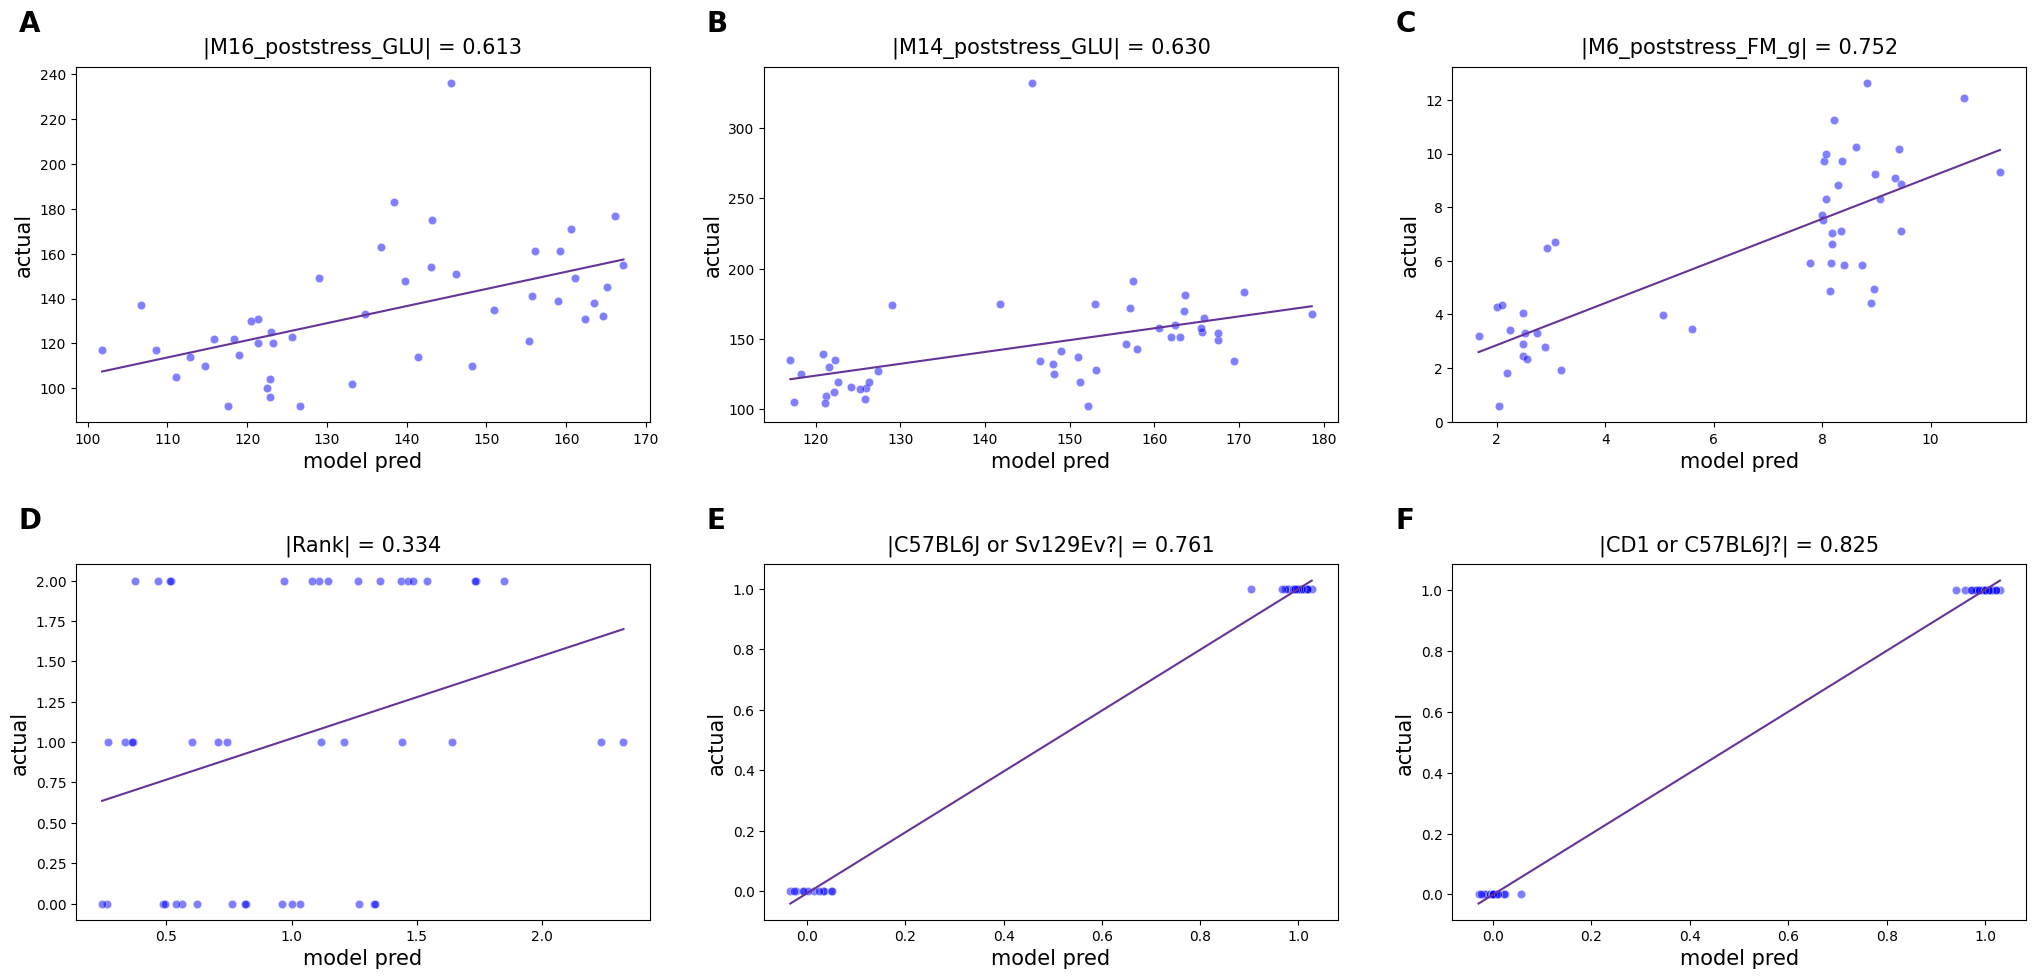

In [5]:
# generate pseudoinversion plots
trait_thresh = 0.60
probe_thresh = 0.50
pinv_dropmin(f_trait_data, meth_data, trait_thresh, 
             find_meth=False, probe_thresh=probe_thresh);

                      627       629       630       633       636       637  \
ID                                                                            
cg06259996_TC21  0.146211  0.154260  0.121491  0.152565  0.144413  0.149819   
cg11548411_BC21  0.223298  0.186412  0.161515  0.184568  0.213074  0.200262   
cg28108944_BC11  0.532768  0.561110  0.550777  0.522043  0.512268  0.565786   
cg28108956_TC21  0.524625  0.527707  0.494442  0.482677  0.522701  0.532902   
cg28108957_BC21  0.549606  0.533730  0.499107  0.498348  0.492761  0.533865   
...                   ...       ...       ...       ...       ...       ...   
cg48343211_TC11  0.205879  0.435466  0.505348  0.515448  0.291100  0.446730   
cg48343225_BC11  0.095217  0.377419  0.254311  0.346717  0.297155  0.289252   
cg48343290_TC21  0.385949  0.208931  0.252605  0.289938  0.367722  0.236867   
cg48343860_TC21  0.384463  0.702253  0.652929  0.571051  0.407764  0.431368   
cg48344016_TC11  0.812896  0.801188  0.798169  0.819

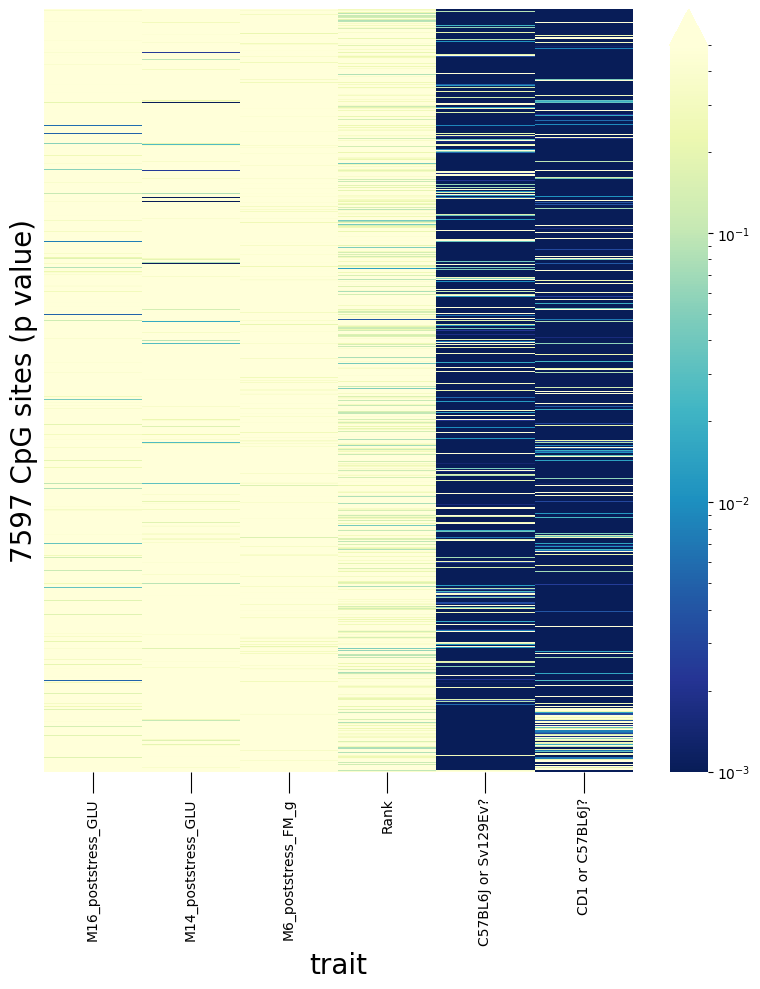

In [6]:
# generate heatmap of probe/trait MMR AdjP values
probe_thresh = 0.50
trait_vals, trait_pvals = pinv_dropmin(f_trait_data, meth_data, trait_thresh, 
                                            find_meth=True, plot_results=True, 
                                            probe_thresh=probe_thresh);

In [7]:
# identify most significant probes
mm39_data = pd.read_excel('mm39_formatted_manifest.xlsx', index_col=0)
probe_df = get_pos(trait_vals, mm39_data);

In [8]:
# Get the number of significant probes for each trait
sig_df = insig_nan(probe_df)
non_nans = sig_df.count()

for column, name in zip(non_nans, sig_df.columns):
    if 'pval' in name:
            # Print the number of non-NaN values for all other pval columns
            print(f'{name[:-5]}: {column}')

print('\n')
count_cumulative_probes(sig_df, 'C57BL6J or Sv129Ev?_pval', 'CD1 or C57BL6J?_pval')
count_cumulative_probes(sig_df, 'M16_poststress_GLU_pval', 'M14_poststress_GLU_pval')

M16_poststress_GLU: 18
M14_poststress_GLU: 58
M6_poststress_FM_g: 0
Rank: 2
C57BL6J or Sv129Ev?: 6304
CD1 or C57BL6J?: 6314


C57BL6J or Sv129Ev?_pval and CD1 or C57BL6J?_pval: 7589
M16_poststress_GLU_pval and M14_poststress_GLU_pval: 75


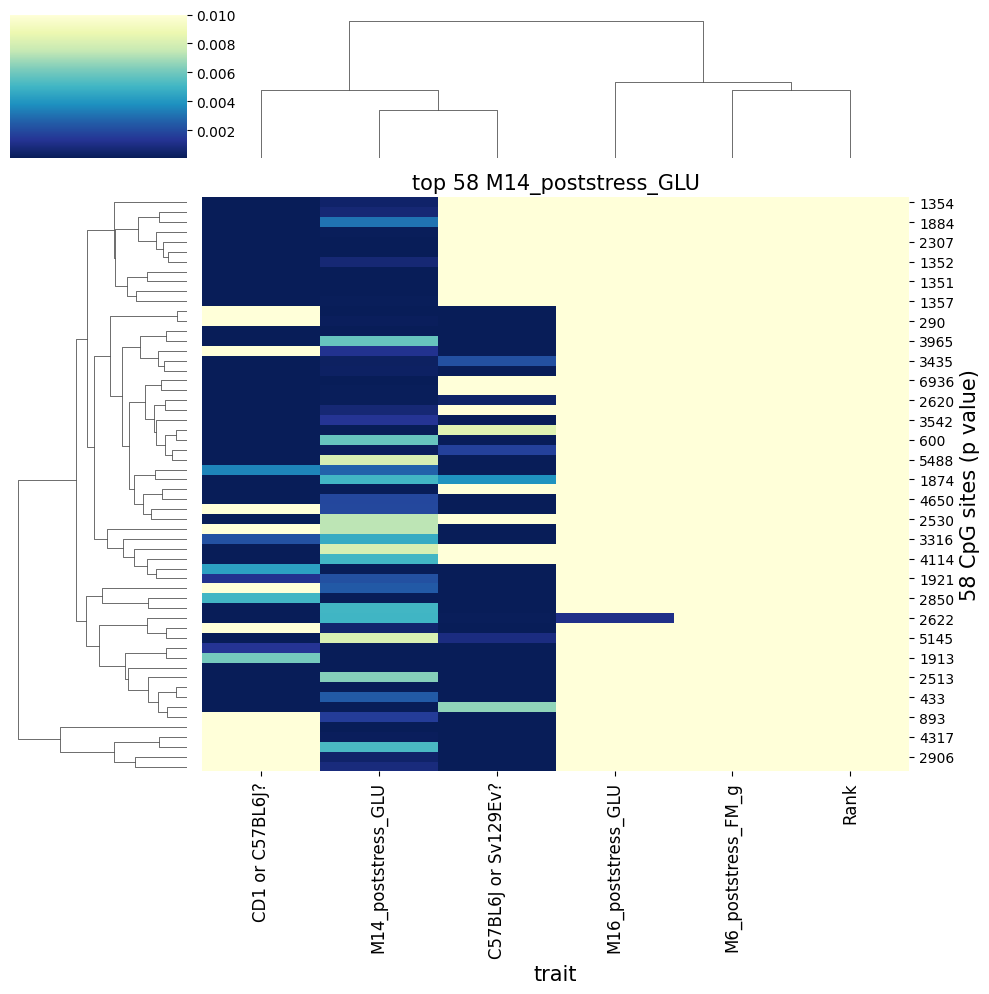

In [9]:
# generate a clustermap of significant probes for selected trait
sig_df = insig_nan(probe_df)
trait = 'M14_poststress_GLU_pval'

temp = sig_df[trait].values
temp = temp[~np.isnan(temp)]
n_probes = len(temp)

trait_cluster(trait_pvals, trait[:-5], n_probes);

In [10]:
# find gene associations of probes via GREAT

temp = probe_df.reset_index()
temp = great_analysis(temp, get='genes', df_chr ='chr_mm10', df_start='pos_mm10', df_end='end_mm10', df_index='index')

temp = temp.set_index('index')
trait_vals['associated_genes'] = temp['associated_genes']

trait_vals.to_excel('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\model_outputs\\pseudoinverse_probes_filtered.xlsx')
trait_vals

,M16_poststress_GLU_pval,M16_poststress_GLU_coef,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,Rank_pval,Rank_coef,C57BL6J or Sv129Ev?_pval,C57BL6J or Sv129Ev?_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes
cg06259996_TC21,0.442692,0.000156,0.930003,-0.000045,0.731469,-0.000922,0.819510,-0.001136,8.149909e-11,-0.062170,3.443799e-09,-0.053636,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)"
cg11548411_BC21,0.177624,0.000262,0.613271,-0.000113,0.817277,-0.000754,0.935813,0.000510,6.893045e-12,-0.080537,6.633491e-11,-0.074531,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)"
cg28108944_BC11,0.997607,-0.000003,0.999171,0.000003,0.832635,0.000933,0.802491,0.001897,1.080646e-05,0.054450,7.563034e-13,0.117291,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)"
cg28108956_TC21,0.627037,0.000183,0.980019,-0.000033,0.702460,-0.001630,0.366508,-0.005738,1.888645e-06,0.062226,4.791962e-13,0.122918,chr6,40524504,40524506,chr6,40547570.0,40547572.0,"Prss37 (-28,063), Olfr461 (+7,479)"
cg28108957_BC21,0.512814,0.000204,0.984136,-0.000029,0.663451,-0.001677,0.288598,-0.006036,2.566893e-04,0.040966,1.445754e-12,0.107946,chr17,49754778,49754780,chr17,49447750.0,49447752.0,"Mocs1 (+19,341), Daam2 (+116,592)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343211_TC11,0.736464,-0.000410,0.191447,0.000776,0.636405,-0.006211,0.565736,-0.012092,4.420755e-12,0.339009,2.748306e-04,-0.136776,chrY,90737336,90737338,chrY,90726067.0,90726069.0,"Gm21996 (-980,536), Erdr1 (-58,670)"
cg48343225_BC11,0.221863,-0.000816,0.996391,0.000022,0.382183,-0.008550,0.155553,-0.021734,2.906974e-15,0.357140,9.939522e-02,-0.047429,chrY,90738474,90738476,chrY,90727205.0,90727207.0,"Gm21996 (-981,674), Erdr1 (-57,532)"
cg48343290_TC21,0.679611,0.000613,0.985188,0.000116,0.844473,-0.003479,0.528672,0.016420,5.354515e-12,0.421989,1.530760e-01,-0.063626,chrY,90742237,90742239,chrY,90730968.0,90730970.0,"Gm21996 (-985,437), Erdr1 (-53,769)"
cg48343860_TC21,0.741660,-0.000584,0.625083,0.000667,0.660268,-0.008165,0.996385,-0.000176,2.078854e-05,0.236036,2.836897e-13,0.549683,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)"


In [11]:
# remove insignificant p values
trait_vals_no_insig = trait_vals.copy()
numeric_cols = trait_vals_no_insig.select_dtypes(include=[np.number]).columns
trait_vals_no_insig[numeric_cols] = trait_vals_no_insig[numeric_cols].applymap(lambda x: np.nan if x > 0.01 else x)

# restore position info
trait_vals_no_insig['pos_mm10'] = trait_vals['pos_mm10']
trait_vals_no_insig['end_mm10'] = trait_vals['end_mm10']
trait_vals_no_insig['pos_mm10'] = trait_vals['pos_mm39']
trait_vals_no_insig['end_mm10'] = trait_vals['end_mm39']

trait_vals_no_insig

C:\Users\Q004\AppData\Local\Temp\ipykernel_65304\3192242794.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trait_vals_no_insig[numeric_cols] = trait_vals_no_insig[numeric_cols].applymap(lambda x: np.nan if x > 0.01 else x)


,M16_poststress_GLU_pval,M16_poststress_GLU_coef,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,Rank_pval,Rank_coef,C57BL6J or Sv129Ev?_pval,C57BL6J or Sv129Ev?_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes
cg06259996_TC21,NaN,0.000156,NaN,-0.000045,NaN,-0.000922,NaN,-0.001136,8.149909e-11,-0.062170,3.443799e-09,-0.053636,chr13,NaN,NaN,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)"
cg11548411_BC21,NaN,0.000262,NaN,-0.000113,NaN,-0.000754,NaN,0.000510,6.893045e-12,-0.080537,6.633491e-11,-0.074531,chr19,NaN,NaN,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)"
cg28108944_BC11,NaN,-0.000003,NaN,0.000003,NaN,0.000933,NaN,0.001897,1.080646e-05,NaN,7.563034e-13,NaN,chr12,NaN,NaN,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)"
cg28108956_TC21,NaN,0.000183,NaN,-0.000033,NaN,-0.001630,NaN,-0.005738,1.888645e-06,NaN,4.791962e-13,NaN,chr6,NaN,NaN,chr6,40547570.0,40547572.0,"Prss37 (-28,063), Olfr461 (+7,479)"
cg28108957_BC21,NaN,0.000204,NaN,-0.000029,NaN,-0.001677,NaN,-0.006036,2.566893e-04,NaN,1.445754e-12,NaN,chr17,NaN,NaN,chr17,49447750.0,49447752.0,"Mocs1 (+19,341), Daam2 (+116,592)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343211_TC11,NaN,-0.000410,NaN,0.000776,NaN,-0.006211,NaN,-0.012092,4.420755e-12,NaN,2.748306e-04,-0.136776,chrY,NaN,NaN,chrY,90726067.0,90726069.0,"Gm21996 (-980,536), Erdr1 (-58,670)"
cg48343225_BC11,NaN,-0.000816,NaN,0.000022,NaN,-0.008550,NaN,-0.021734,2.906974e-15,NaN,NaN,-0.047429,chrY,NaN,NaN,chrY,90727205.0,90727207.0,"Gm21996 (-981,674), Erdr1 (-57,532)"
cg48343290_TC21,NaN,0.000613,NaN,0.000116,NaN,-0.003479,NaN,NaN,5.354515e-12,NaN,NaN,-0.063626,chrY,NaN,NaN,chrY,90730968.0,90730970.0,"Gm21996 (-985,437), Erdr1 (-53,769)"
cg48343860_TC21,NaN,-0.000584,NaN,0.000667,NaN,-0.008165,NaN,-0.000176,2.078854e-05,NaN,2.836897e-13,NaN,chrY,NaN,NaN,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)"


In [12]:
# combine the strain-associated traits into a single column for analysis, and do the same for the blood glucose associated traits

# strain
cistrome_formatted = trait_vals_no_insig.copy()

cistrome_formatted['Strain_pval'] = cistrome_formatted.apply(lambda row: np.nanmean([row['C57BL6J or Sv129Ev?_pval'], row['CD1 or C57BL6J?_pval']]) 
                        if pd.notna(row['C57BL6J or Sv129Ev?_pval']) or pd.notna(row['CD1 or C57BL6J?_pval']) 
                        else np.nan, axis=1)
cistrome_formatted = cistrome_formatted.drop(columns=['C57BL6J or Sv129Ev?_pval', 'CD1 or C57BL6J?_pval']) # dont need to bother with coef

# blood glucose
cistrome_formatted['Blood Glucose_pval'] = cistrome_formatted.apply(lambda row: np.nanmean([row['M14_poststress_GLU_pval'], row['M16_poststress_GLU_pval']]) 
                        if pd.notna(row['M14_poststress_GLU_pval']) or pd.notna(row['M16_poststress_GLU_pval']) 
                        else np.nan, axis=1)
cistrome_formatted = cistrome_formatted.drop(columns=['M14_poststress_GLU_pval', 'M16_poststress_GLU_pval']) # dont need to bother with coef

# drop rank because it doesn't produce any factors (only 2 probes anyways)
cistrome_formatted = cistrome_formatted.drop(columns=['Rank_pval']) # dont need to bother with coef
cistrome_formatted

,M16_poststress_GLU_coef,M14_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,Rank_coef,C57BL6J or Sv129Ev?_coef,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes,Strain_pval,Blood Glucose_pval
cg06259996_TC21,0.000156,-0.000045,NaN,-0.000922,-0.001136,-0.062170,-0.053636,chr13,NaN,NaN,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)",1.762649e-09,NaN
cg11548411_BC21,0.000262,-0.000113,NaN,-0.000754,0.000510,-0.080537,-0.074531,chr19,NaN,NaN,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)",3.661398e-11,NaN
cg28108944_BC11,-0.000003,0.000003,NaN,0.000933,0.001897,NaN,NaN,chr12,NaN,NaN,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)",5.403232e-06,NaN
cg28108956_TC21,0.000183,-0.000033,NaN,-0.001630,-0.005738,NaN,NaN,chr6,NaN,NaN,chr6,40547570.0,40547572.0,"Prss37 (-28,063), Olfr461 (+7,479)",9.443227e-07,NaN
cg28108957_BC21,0.000204,-0.000029,NaN,-0.001677,-0.006036,NaN,NaN,chr17,NaN,NaN,chr17,49447750.0,49447752.0,"Mocs1 (+19,341), Daam2 (+116,592)",1.283446e-04,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343211_TC11,-0.000410,0.000776,NaN,-0.006211,-0.012092,NaN,-0.136776,chrY,NaN,NaN,chrY,90726067.0,90726069.0,"Gm21996 (-980,536), Erdr1 (-58,670)",1.374153e-04,NaN
cg48343225_BC11,-0.000816,0.000022,NaN,-0.008550,-0.021734,NaN,-0.047429,chrY,NaN,NaN,chrY,90727205.0,90727207.0,"Gm21996 (-981,674), Erdr1 (-57,532)",2.906974e-15,NaN
cg48343290_TC21,0.000613,0.000116,NaN,-0.003479,NaN,NaN,-0.063626,chrY,NaN,NaN,chrY,90730968.0,90730970.0,"Gm21996 (-985,437), Erdr1 (-53,769)",5.354515e-12,NaN
cg48343860_TC21,-0.000584,0.000667,NaN,-0.008165,-0.000176,NaN,NaN,chrY,NaN,NaN,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)",1.039427e-05,NaN


No valid probes, skipping trait M6_poststress_FM_g_pval


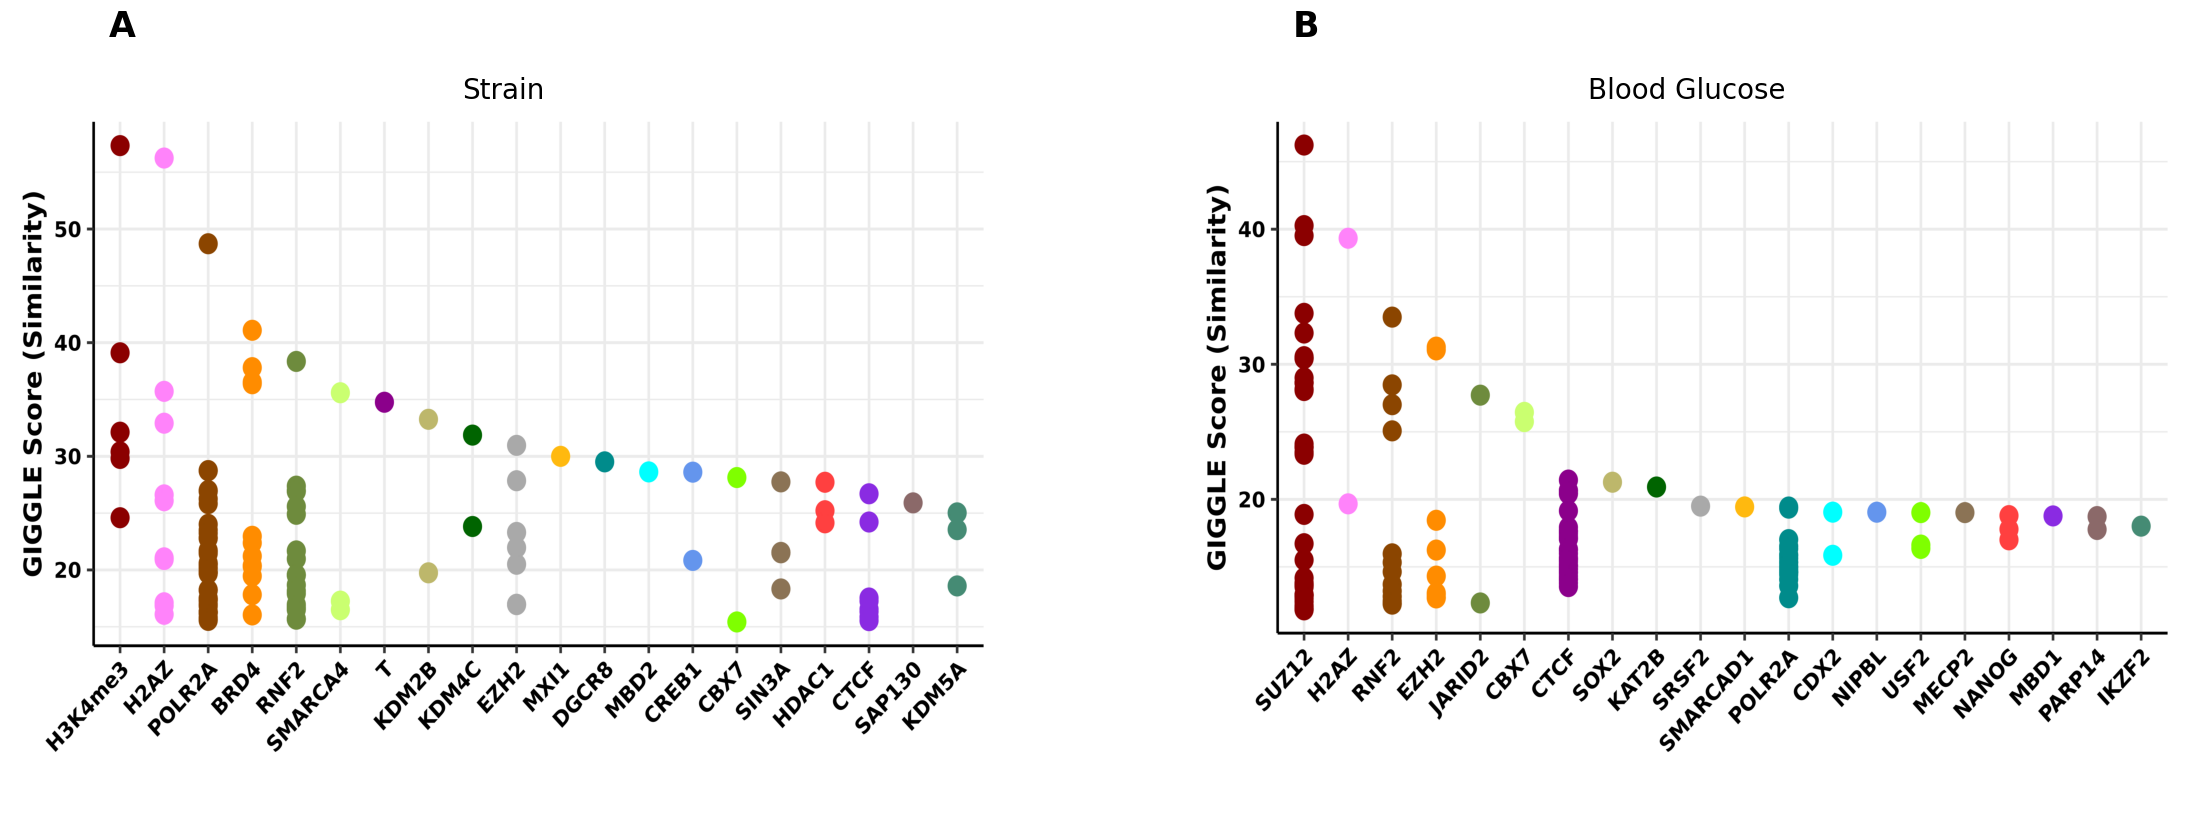

In [13]:
# get cistrome plots using probes

%matplotlib inline

# this is trial and error, unfortunately 
fig_w = 2800
fig_h = 2000 #3500 for 3/4, 5000 for 5/6

# generate cistrome plots by trait
get_cistrome(cistrome_formatted, fig_w, fig_h)